# Manifold Learning with Local Linear Embedding

Several techniques approximate a lower dimensional manifold. One example is [locally-linear embedding](https://cs.nyu.edu/~roweis/lle/) (LLE) that was developed in 2000 by Sam Roweis and Lawrence Saul.
 
This notebook demonstrates how LLE ‘unrolls’ the swiss roll, and how it performs on other data. 

For each data point, LLE identifies a given number of nearest neighbors and computes weights that represent each point as a linear combination of its neighbors. It finds a lower-dimensional embedding by linearly projecting each neighborhood on global internal coordinates on the lower-dimensional manifold and can be thought of as a sequence of PCA applications.

## Imports & Settings

In [1]:
%matplotlib inline
from pathlib import Path
from os.path import join

import numpy as np
from numpy.random import choice, uniform, randn
import pandas as pd

from sklearn.datasets import make_swiss_roll, make_s_curve
from sklearn.manifold import locally_linear_embedding
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FuncFormatter

import ipyvolume as ipv
import ipyvolume.pylab as p3
from ipywidgets import HBox

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import colorlover as cl

In [2]:
sns.set_style('white')

In [3]:
DATA_PATH = Path('..', '..', 'data')

In [4]:
init_notebook_mode(connected=True)
ipv_cmap = sns.color_palette("Paired", n_colors=10)

## A Simple Linear Manifold: Ellipse in 3D 

In [5]:
n_points, noise = 1000, 0.1
angles = uniform(low=-np.pi, high=np.pi, size=n_points)
x = 2 * np.cos(angles) + noise * randn(n_points)
y = np.sin(angles) + noise * randn(n_points)

theta = np.pi/4 # 45 degree rotation
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                            [np.sin(theta), np.cos(theta)]])

rotated = np.column_stack((x, y)).dot(rotation_matrix)
x, y = rotated[:, 0], rotated[:, 1]

z = .2 * x  + .2 * y + noise * randn(n_points)
ellipse3d = np.vstack((x, y, z)).T

### PCA: Linear Dimensionality Reduction finds some manifolds

PCA is able to recover the 2D manifold. 

In [6]:
def get_2d_projection(data, pc):
    min_, max_ = data[:, :2].min(0), data[:, :2].max(0)
    X, Y = np.meshgrid(np.linspace(min_[0], max_[0], 50),
                       np.linspace(min_[1], max_[1], 50))

    nv = np.cross(pc.components_[0], pc.components_[1])
    d = -pc.mean_.dot(nv)
    Z = (-nv[0] * X - nv[1] * Y - d) * 1 / nv[2]
    factor = max(data[:, -1].min() / Z.min(), data[:, -1].max()/Z.max())
    return X, Y, Z * factor

In [7]:
pca = PCA(n_components=2)
ellipse2d = pca.fit_transform(ellipse3d)

In [8]:
znorm = z - z.min()
znorm /= znorm.ptp()
color = cm.viridis(znorm)

xs, ys, zs = get_2d_projection(ellipse3d, pca)
p3.figure(width=600, height=600)
p3.plot_wireframe(xs, ys, zs, color="black")
p3.scatter(x, y, z, marker='sphere', color=color[:,0:3], size=1)
p3.view(azimuth=45, elevation=75)
p3.show()

## Swiss Roll

In [9]:
n_samples = 10000
palette = sns.color_palette('viridis', n_colors=n_samples)
zeros = np.zeros(n_samples) + .5

Create 2D version by sorting datapoints by value and plotting using x, y coordinates only

In [10]:
swiss_3d, swiss_val = make_swiss_roll(n_samples=n_samples,
                                      noise=.1,
                                      random_state=42)

swiss_3d = swiss_3d[swiss_val.argsort()[::-1]]
x, y, z = swiss_3d.T

In [11]:
p3.figure()
p3.scatter(np.sort(swiss_val), y, zeros, marker='sphere', color=palette, size=1)
p3.xlim(swiss_val.min(), swiss_val.max())
fig = p3.gcc()

The left box shows the 3D version, the right box shows the 2D manifold that is home to the swiss roll.

In [12]:
HBox([
    ipv.quickscatter(x, y, z, size=1, color=palette, marker='sphere'),
    fig
])

### Linear cuts along the axes

Linear methods will have a hard time.

In [13]:
p3.figure(width=400, height=400)
p3.scatter(zeros, y, z, marker='sphere', color=palette, size=1)
p3.view(azimuth=15, elevation=45)
fig1 = p3.gcc()

In [14]:
p3.figure(width=400, height=400)
p3.scatter(x, zeros, z, marker='sphere', color=palette, size=1)
p3.view(azimuth=15, elevation=45)
fig2 = p3.gcc()

In [15]:
p3.figure(width=400, height=400)
p3.scatter(x, y, zeros, marker='sphere', color=palette, size=1)
p3.view(azimuth=15, elevation=45)
fig3 = p3.gcc()

In [16]:
HBox([
    fig1, fig2, fig3]
)

### Can PCA find the Swiss Roll Manifold?

In [17]:
pca = PCA(n_components=2)
swiss_2d = pca.fit_transform(swiss_3d)

In [18]:
p3.figure(width=400, height=400)
xs, ys, zs = get_2d_projection(swiss_3d, pca)
p3.plot_wireframe(xs, ys, zs, color='black')
p3.scatter(*swiss_3d.T, marker='sphere', color=palette, size=1)
p3.view(azimuth=15, elevation=45)
fig1 = p3.gcc()

In [19]:
p3.figure(width=400, height=400)

min_2d, max_2d = swiss_2d[:, :2].min(0), swiss_2d[:, :2].max(0)
x2d, y2d = np.meshgrid(np.linspace(min_2d[0], max_2d[0], 100),
                     np.linspace(min_2d[1], max_2d[1], 100))
p3.plot_wireframe(x2d, y2d, np.zeros(shape=(100, 100)) + .5, color='black'),

p3.scatter(*np.c_[swiss_2d, np.zeros(n_samples) + .5].T,
           marker='sphere', color=palette, size=1)
p3.view(azimuth=45, elevation=45)
fig2 = p3.gcc()

PCA is unable to capture the manifold structure and instead squashes the swiss roll sideways:

In [20]:
HBox([
fig1, fig2]
)

### Manifold learning can make a classification task linear

We'll compare two cases with very different spatial location of the classes.

In [21]:
cpos, cneg = 'red', 'blue'

In [22]:
pos_class = swiss_3d[:, 0] > 4
X_pos = swiss_3d[pos_class, :]
X_neg = swiss_3d[~pos_class, :]

In [23]:
p3.figure(width=400, height=400)
p3.scatter(*X_pos.T, marker='sphere', color=cpos, size=1)
p3.scatter(*X_neg.T, marker='sphere', color=cneg, size=1)
p3.view(azimuth=15, elevation=45)
fig1 = p3.gcc()

In [24]:
p3.figure(width=400, height=400)
p3.scatter(np.sort(swiss_val)[pos_class],
           X_pos[:, 1],
           zeros, marker='sphere',
           color=cpos,
           size=1)
p3.scatter(np.sort(swiss_val)[~pos_class],
           X_neg[:, 1],
           zeros, marker='sphere',
           color=cneg, size=1)
p3.view(azimuth=15, elevation=45)
fig2 = p3.gcc()

In [25]:
HBox([fig1, fig2])

In [26]:
pos_class = 2 * (np.sort(swiss_val) - 4) > swiss_3d[:, 1]
X_pos = swiss_3d[pos_class]
X_neg = swiss_3d[~pos_class]

In [27]:
p3.figure(width=600, height=400)
p3.scatter(*X_pos.T, marker='sphere', color=cpos, size=1)
p3.scatter(*X_neg.T, marker='sphere', color=cneg, size=1)
p3.view(azimuth=15, elevation=45)
fig1 = p3.gcc()

In [28]:
p3.figure(width=600, height=400)
p3.scatter(np.sort(swiss_val)[pos_class], X_pos[:, 1], zeros,marker='sphere', color=cpos, size=1)
p3.scatter(np.sort(swiss_val)[~pos_class], X_neg[:, 1], zeros,marker='sphere', color=cneg, size=1)
p3.view(azimuth=15, elevation=45)
fig2 = p3.gcc()

In this case, the classes are linearly seperable given their manifold.

In [29]:
HBox([fig1, fig2])

### Local-Linear Embedding learns the Swill Roll manifold

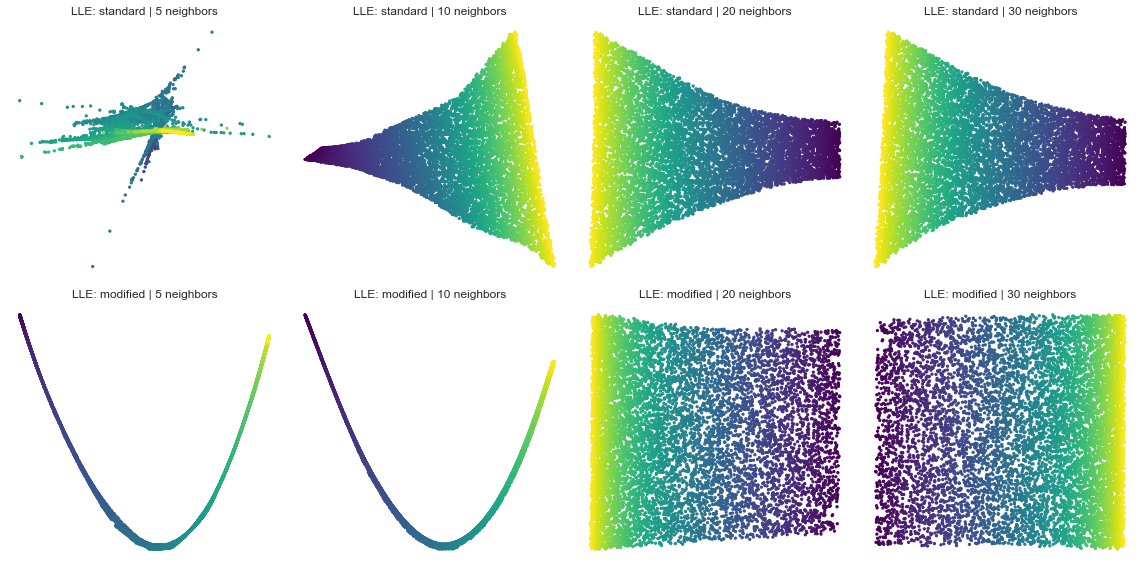

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

for row, method in enumerate(['standard', 'modified']):
    for col, n_neighbors in enumerate([5, 10, 20, 30]):
        embedded, err = locally_linear_embedding(swiss_3d,
                                                 n_neighbors=n_neighbors,
                                                 n_components=2,
                                                 method=method,
                                                 random_state=42)
        axes[row, col].scatter(*embedded.T, c=palette, s=5)
        axes[row, col].set_title(f'LLE: {method} | {n_neighbors} neighbors')
        axes[row, col].set_axis_off()

fig.tight_layout()

## S-Curve

In [31]:
scurve_3d, scurve_val = make_s_curve(
    n_samples=n_samples, noise=.05, random_state=42)
scurve_3d = scurve_3d[scurve_val.argsort()[::-1]]
scurve_3d[:, 1] *= 10

### Can PCA identify the S-Curve Manifold?

In [32]:
pca = PCA(n_components=2)
scurve_2d = pca.fit_transform(scurve_3d)

In [33]:
p3.figure(width=500, height=500)
xs, ys, zs = get_2d_projection(scurve_3d, pca)
p3.plot_wireframe(xs, ys, zs, color='black')
p3.scatter(*scurve_3d.T, marker='sphere', color=palette, size=1)
p3.view(azimuth=15, elevation=45)
fig1 = p3.gcc()

In [34]:
p3.figure(width=500, height=500)

min_2d, max_2d = scurve_2d[:, :2].min(0), scurve_2d[:, :2].max(0)
x2d, y2d = np.meshgrid(np.linspace(min_2d[0], max_2d[0], 100),
                       np.linspace(min_2d[1], max_2d[1], 100))
p3.plot_wireframe(x2d, y2d, np.zeros(shape=(100, 100)) + .5, color='black'),

p3.scatter(*np.c_[scurve_2d, np.zeros(n_samples) + .5].T,
           marker='sphere', color=palette, size=1)
p3.view(azimuth=45, elevation=45)
fig2 = p3.gcc()

In [35]:
HBox([
fig1, fig2]
)

### Local-Linear Embedding

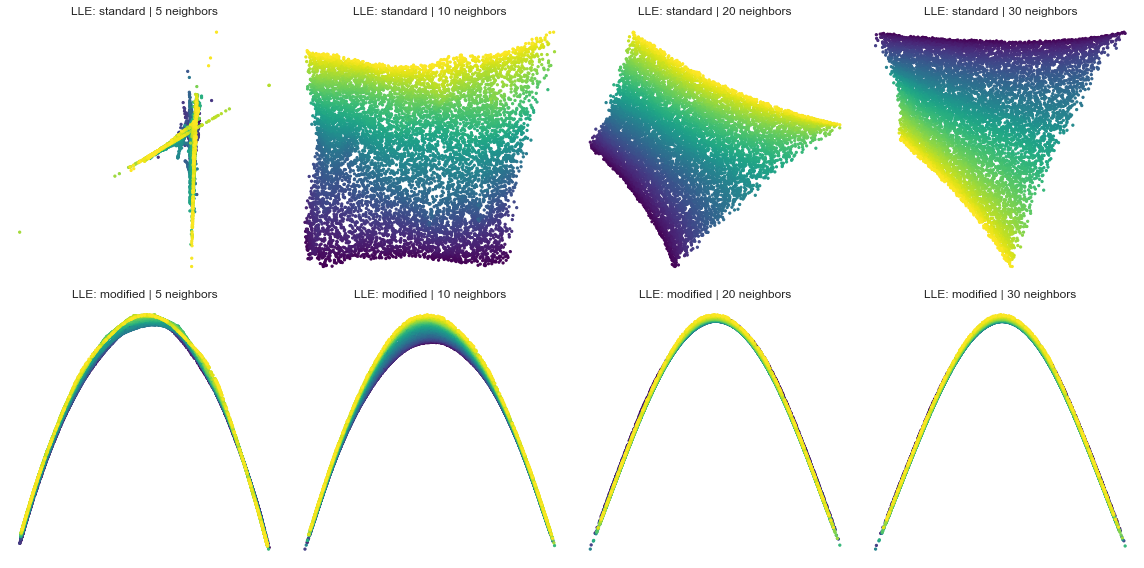

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for row, method in enumerate(['standard', 'modified']):
    for col, n_neighbors in enumerate([5, 10, 20, 30]):
        embedded, err = locally_linear_embedding(scurve_3d,
                                                 n_neighbors=n_neighbors,
                                                 n_components=2,
                                                 method=method,
                                                 random_state=42)
        axes[row, col].scatter(*embedded.T, c=palette, s=5)
        axes[row, col].set_title(f'LLE: {method} | {n_neighbors} neighbors')
        axes[row, col].set_axis_off()
fig.tight_layout()

## Handwritten Digits - MNIST Data

### Load Data

In [37]:
mnist_path = DATA_PATH / 'mnist'

In [38]:
mnist_data = np.load(mnist_path / 'data.npy')
mnist_label = np.load(mnist_path / 'labels.npy')

digits = np.arange(10)

FileNotFoundError: [Errno 2] No such file or directory: '..\\..\\data\\mnist\\data.npy'

#### Visualize Data

In [ ]:
h = w = int(np.sqrt(mnist_data.shape[1])) # 28 x 28 pixels
n_samples = 15

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))
mnist_sample = np.empty(shape=(h * len(digits),
                               w * n_samples))

for row, label in enumerate(digits):
    label_idx = np.argwhere(mnist_label == label).squeeze()
    sample_indices = choice(label_idx, size=n_samples, replace=False)
    i = row * h
    for col, sample_idx in enumerate(sample_indices):
        j = col * w
        sample = mnist_data[sample_idx].reshape(h, w)
        mnist_sample[i:i+h, j:j + w] = sample

ax.imshow(mnist_sample, cmap='Blues')
ax.set_title('MNIST Images', fontsize=16)
plt.axis('off')
fig.tight_layout()

### PCA

#### Explained Variance

In [ ]:
n_components = 20
mnist_pca = PCA(n_components=n_components)
mnist_pca.fit(mnist_data)

In [ ]:
ev = pd.Series(mnist_pca.explained_variance_ratio_,
               index=list(range(1, n_components+1)))
ev.sort_values().plot.barh(figsize=(8, 4))
sns.despine()
plt.tight_layout()

In [ ]:
n_components = 20
pca = PCA(n_components=n_components)
explained_var = pd.DataFrame(index=list(range(1, n_components + 1)))
for digit in digits:
    digit_data = mnist_data[mnist_label == digit]
    pca.fit(digit_data)
    explained_var[digit] = pca.explained_variance_ratio_

The below plot illustrates how much more variance PCA is able to capture for individual digits.

In [ ]:
axes = explained_var.cumsum().plot(subplots=True,
                                   layout=(2, 5),
                                   figsize=(14, 6),
                                   rot=0,
                                   lw=1,
                                   sharey=True,
                                   xlim=(1, 20),
                                   color='k',
                                   title=list(digits),
                                   legend=False)
for ax in axes.flatten():
    ev.cumsum().plot(ax=ax,
                     lw=1,
                     c='k',
                     ls='--',
                     label='All Digits',
                     legend=True)
    ax.set_xlabel('# Components')
    ax.set_ylabel('Explained Variance (%)')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

plt.gcf().suptitle('Explained Variance: Individual Digits vs All Digits', fontsize=14)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=.9)

#### 2D Projection

In [ ]:
mnist_pca = PCA(n_components=2)
mnist_pca_2d = mnist_pca.fit_transform(mnist_data)

In [ ]:
color = [sns.color_palette('Paired', 10)[int(i)] for i in mnist_label]

In [ ]:
mnist_pca_df = pd.DataFrame(mnist_pca_2d, columns=['x', 'y']).assign(color=mnist_label)

In [ ]:
ipv_cmap = sns.color_palette("Paired", n_colors=10)
print(digits)
sns.palplot(ipv_cmap)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.scatterplot(x='x', y='y', hue='color',
                data=mnist_pca_df, legend='full', ax=ax, 
                palette=sns.color_palette('Paired', 10))
plt.axis('off')
ax.set_title('PCA 2D Projection of MNIST Data')
fig.tight_layout()

### Local Linear Embedding

The following `locally_linear_embedding` on `mnist.data` takes fairly long to run, hence we are providing pre-computed results so you can explore the visualizations regardless of your hardware setup.

In [ ]:
# commented out to avoid long run time
# lle, err = locally_linear_embedding(X=mnist.data, n_components=2, n_neighbors=20, method='standard')

In [ ]:
mnist_path = Path('data', 'mnist')
mnist_lle_path = mnist_path / 'lle'

In [ ]:
mnist_labels = np.load(mnist_path / 'labels.npy')
color = [sns.color_palette('Paired', 10)[int(i)] for i in mnist_labels]

#### 2D Projection

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

for row, method in enumerate(['standard', 'modified']):
    for col, n_neighbors in enumerate([20, 50, 100, 200]):
        x, y = np.load(mnist_lle_path / method / f'{n_neighbors}.npy').T
        axes[row, col].scatter(x, y, c=color, s=5)
        axes[row, col].set_title(f'LLE: {method} | {n_neighbors} neighbors')
        axes[row, col].set_axis_off()
fig.tight_layout()

#### Plotly Visualization

In [ ]:
plotly_cmap = cl.to_rgb( cl.scales['10']['qual']['Paired'])
def plotly_scatter(data, label, title, color, x='x', y='y'):
    fig = dict(
        data=[
            dict(
                type='scattergl',
                x=data[:, 0],
                y=data[:, 1],
                legendgroup="group",
                text=label.astype(int),
                mode='markers',
                marker=dict(
                    size=5,
                    color=color,
                    autocolorscale=True,
                    showscale=False,
                    opacity=.9,
                    colorbar=go.scattergl.marker.ColorBar(
                        title='Class'
                    ),
                    line=dict(width=1))),
        ],
        layout=dict(title=title,
                    width=1200,
                    font=dict(color='white'),
                    xaxis=dict(
                        title=x, 
                        hoverformat='.1f', 
                        showgrid=False),
                    yaxis=dict(title=y, 
                               hoverformat='.1f', 
                               showgrid=False),
                    paper_bgcolor='rgba(0,0,0,0)',
                    plot_bgcolor='rgba(0,0,0,0)'
                    ))

    iplot(fig, show_link=False)

In [ ]:
method = 'standard'
n_neigbhors = 100
embedding = np.load(mnist_lle_path / method / f'{n_neigbhors}.npy')
color = [plotly_cmap[int(i)] for i in mnist_labels]
plotly_scatter(embedding, mnist_labels, color=color, title='Local Linear Embedding (Standard) | 100 Neighbors')

## Fashion MNIST Data

### Load Data

In [ ]:
fashion_path = DATA_PATH / 'fashion_mnist'

In [ ]:
fashion_data = np.load(fashion_path / 'data.npy')
fashion_label = np.load(fashion_path / 'labels.npy')

classes = sorted(np.unique(fashion_label).astype(int))

In [ ]:
named_classes = pd.read_csv(fashion_path / 'label_dict.csv', 
                            squeeze=True, 
                            header=None).to_list()

### Visualize Data

In [ ]:
h = w = int(np.sqrt(fashion_data.shape[1])) # 28 x 28 pixels
n_samples = 15

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))
fashion_sample = np.empty(shape=(h * len(classes),
                                 w * n_samples))

for row, label in enumerate(classes):
    label_idx = np.argwhere(fashion_label == label).squeeze()
    sample_indices = choice(label_idx, size=n_samples, replace=False)
    i = row * h
    for col, sample_idx in enumerate(sample_indices):
        j = col * w
        sample = fashion_data[sample_idx].reshape(h, w)
        fashion_sample[i:i+h, j:j + w] = sample

ax.imshow(fashion_sample, cmap='Blues')
ax.set_title('Fashion Images', fontsize=16)
plt.axis('off')
fig.tight_layout()

### PCA

In [ ]:
n_components = 20
mnist_pca = PCA(n_components=n_components)
mnist_pca.fit(fashion_data)

#### Explained Variance

In [ ]:
ev = pd.Series(mnist_pca.explained_variance_ratio_,
               index=list(range(1, n_components+1)))
ev.sort_values().plot.barh(figsize=(8, 4))
sns.despine()
plt.tight_layout()

In [ ]:
n_components = 20
pca = PCA(n_components=n_components)
explained_var = pd.DataFrame(index=list(range(1, n_components + 1)))
for label in classes:
    class_data = fashion_data[fashion_label == label]
    pca.fit(class_data)
    explained_var[label] = pca.explained_variance_ratio_

The below plot illustrates how much more variance PCA is able to capture for individual digits.

In [ ]:
axes = explained_var.cumsum().plot(subplots=True,
                                   layout=(2, 5),
                                   figsize=(14, 6),
                                   rot=0,
                                   lw=1,
                                   sharey=True,
                                   xlim=(1, 20),
                                   color='k',
                                   title=named_classes,
                                   legend=False)
for ax in axes.flatten():
    ev.cumsum().plot(ax=ax,
                     lw=1,
                     c='k',
                     ls='--',
                     label='All Digits',
                     legend=True)
    ax.set_xlabel('# Components')
    ax.set_ylabel('Explained Variance (%)')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

plt.gcf().suptitle('Explained Variance: Individual Classes vs All Classes', fontsize=14)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=.9)

#### 2D Projection

In [ ]:
fashion_pca = PCA(n_components=2)
fashion_pca_2d = fashion_pca.fit_transform(fashion_data)

In [ ]:
fashion_pca_df = pd.DataFrame(fashion_pca_2d, columns=['x', 'y']).assign(color=fashion_label)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.scatterplot(x='x', y='y', hue='color',
                data=fashion_pca_df,
                legend='full',
                ax=ax,
                palette=sns.color_palette('Paired', 10))
plt.axis('off')
ax.set_title('PCA 2D Projection of Fashion MNIST Data')
fig.tight_layout()

#### 3D Projection

In [ ]:
pca = PCA(n_components=3)
fashion_3d = pca.fit_transform(fashion_data)
pd.Series(pca.explained_variance_ratio_)

In [ ]:
ipv_color = [ipv_cmap[int(t)] for t in fashion_label]
ipv.quickscatter(*fashion_3d.T, size=.5, color=ipv_color, marker='sphere')

### Local Linear Embedding

#### 2D Projection

In [ ]:
fashion_lle_path = Path('data', 'fashion')

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 8))
labels = np.load(fashion_lle_path / 'labels.npy')
color = [sns.color_palette('Paired', 10)[int(i)] for i in labels]
for row, method in enumerate(['standard', 'modified']):
    for col, n_neighbors in enumerate([20, 45, 100, 200, 500]):
        x, y = np.load(fashion_lle_path / 'lle' / method / f'{n_neighbors}.npy').T
        axes[row, col].scatter(x, y, c=color, s=5)
        axes[row, col].set_title(
            f'LLE: {method} | {n_neighbors} neighbors')
        axes[row, col].set_axis_off()
fig.tight_layout()

#### Plotly Visualization

In [ ]:
method, n_neighbors = 'standard', 200
embedding = np.load(fashion_lle_path / 'lle' / method / f'{n_neighbors}.npy')
color = [plotly_cmap[int(i)] for i in labels]
plotly_scatter(embedding, labels, color=color,
               title='Local Linear Embedding (Standard) | 200 Neighbors')